In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

/var/folders/f5/3603lrxn363_ddpmt3c65sfm0000gn/T/ipykernel_3456/1960879352.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#Data loading

In [2]:
#grid bogota data.
gdf_grilla = gpd.read_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogora.geojson',driver='GeoJSON')
gdf_grilla.head()

,geometry
0,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654..."
1,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550..."
2,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445..."
3,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341..."
4,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236..."


In [3]:
gdf_grilla.shape

(984, 1)

#Adding tgp (tasa general de desempleo) for each grid cell

In [4]:
tgp = gpd.read_file('../Data/Bogota/Raw Data/covariates/tgp.geojson',driver='GeoJSON')
tgp.head()

,LocCodigo,LocNombre,tpg2011,tpg2014,tpg2017,SHAPE_Leng,SHAPE_Area,geometry
0,15,15,61.453061,60.183802,61.513876,0.108973,0.000397,"POLYGON ((-74.13075 4.59335, -74.12917 4.59327..."
1,6,6,61.109606,63.988318,57.754459,0.210542,0.000807,"POLYGON ((-74.13777 4.59489, -74.13165 4.59363..."
2,18,18,61.755117,63.635931,61.003204,0.174513,0.001126,"POLYGON ((-74.12803 4.59254, -74.12777 4.59233..."
3,1,1,61.249926,59.935160,64.027285,0.436907,0.005310,"POLYGON ((-74.01116 4.66459, -74.01117 4.66460..."
4,2,2,66.446775,65.587775,63.530659,0.333966,0.003095,"POLYGON ((-74.01116 4.66459, -74.01154 4.66461..."


In [5]:
# 1. same crs
gdf_grilla = gdf_grilla.to_crs('EPSG:4326')
tgp = tgp.to_crs('EPSG:4326')

# 2. adding unic id for each cell in the grid.
gdf_grilla = gdf_grilla.reset_index(drop=True)
gdf_grilla['grid_id'] = gdf_grilla.index

# 3. Spatial join: asociar cada tgp con la celda que lo contiene (o intersecta)
joined = gpd.sjoin(tgp, gdf_grilla, how='inner', predicate='intersects')

# 4. groping by grid_id and making the average for tpg2017
promedios = joined.groupby('grid_id')['tpg2017'].mean().reset_index()

# 5. mergin with the average values
gdf_grilla = gdf_grilla.merge(promedios, on='grid_id', how='left')

gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,geometry,grid_id,tpg2017
0,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",0,NaN
1,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",1,NaN
2,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",2,NaN
3,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",3,NaN
4,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",4,NaN


<Axes: >

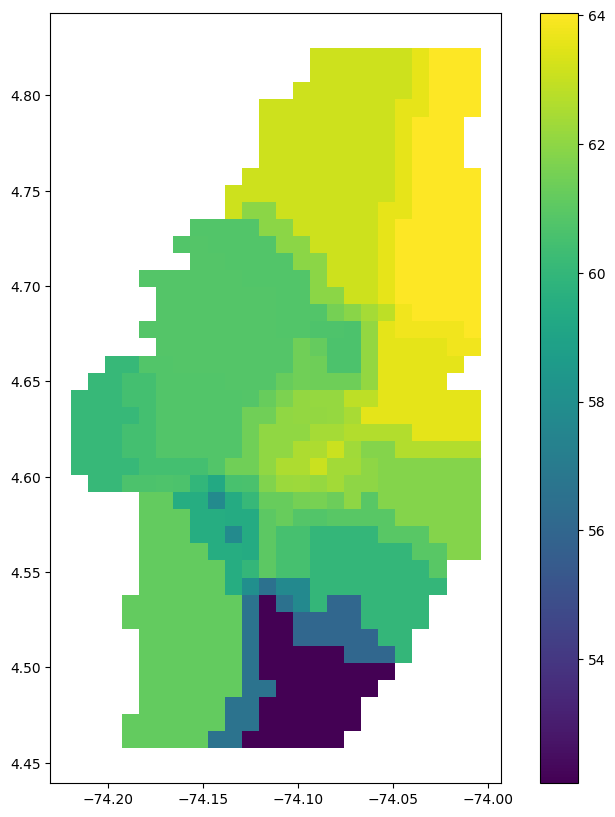

In [6]:
del tgp
gdf_grilla.plot(column='tpg2017', cmap='viridis', legend=True, figsize=(10,10))


#Adding population for each grid cell

In [7]:
population = gpd.read_file('../Data/Bogota/Raw Data/covariates/population.geojson',driver='GeoJSON')
population.head()

,cod_loc,nomb_loc,cod_upz,nom_upz,area_urbana_en_hectareas_ha,poblacion_urbana,densidad_urbana,geo_point_2d,geometry
0,2.0,CHAPINERO,90,PARDO RUBIO,285.199005,37191.0,130.403681,"{'lon': -74.05669033622166, 'lat': 4.640899925...","POLYGON ((-74.05816 4.65070, -74.05802 4.65087..."
1,3.0,SANTA FE,96,LOURDES,200.137127,46301.0,231.346381,"{'lon': -74.0715182699691, 'lat': 4.5849177416...","POLYGON ((-74.06010 4.60224, -74.05979 4.60211..."
2,4.0,SAN CRISTOBAL,50,LA GLORIA,385.857759,102299.0,265.121013,"{'lon': -74.08912872684135, 'lat': 4.546680403...","POLYGON ((-74.10639 4.56384, -74.10643 4.56389..."
3,5.0,USME,61,CIUDAD USME,925.470477,13496.0,14.582853,"{'lon': -74.12187786293549, 'lat': 4.469594515...","POLYGON ((-74.10795 4.49444, -74.10809 4.49417..."
4,6.0,TUNJUELITO,42,VENECIA,659.377024,144420.0,219.024920,"{'lon': -74.13942680856923, 'lat': 4.582982810...","POLYGON ((-74.15226 4.59568, -74.15172 4.59547..."


<Axes: >

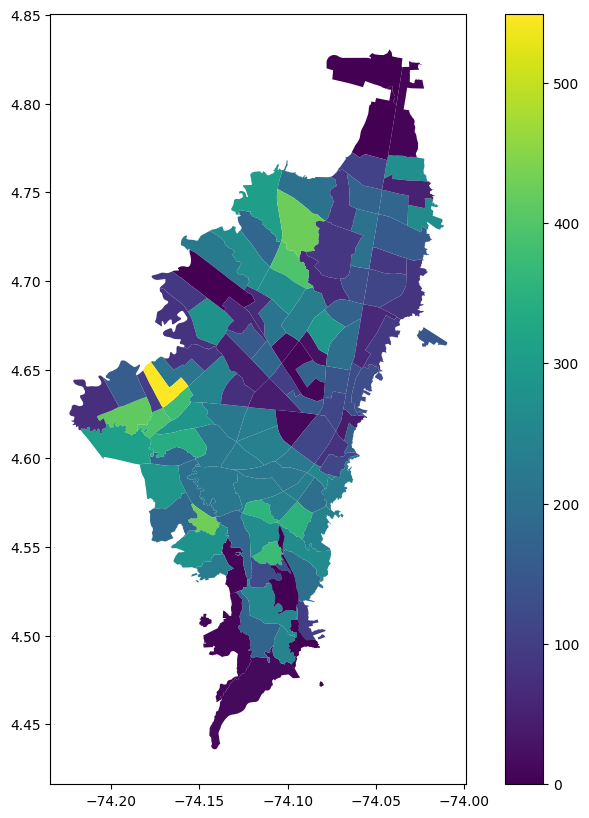

In [8]:
population.plot(column='densidad_urbana', cmap='viridis', legend=True, figsize=(10,10))

In [9]:
# 1. same crs
gdf_grilla = gdf_grilla.to_crs('EPSG:4326')
population = population.to_crs('EPSG:4326')

# 2. adding unic id for each cell in the grid.
gdf_grilla = gdf_grilla.reset_index(drop=True)
gdf_grilla['grid_id'] = gdf_grilla.index

# 3. Spatial join: asociar cada tgp con la celda que lo contiene (o intersecta)
joined = gpd.sjoin(population, gdf_grilla, how='inner', predicate='intersects')

# 4. groping by grid_id and making the average
promedios = joined.groupby('grid_id')['densidad_urbana'].mean().reset_index()

# 5. mergin with the average values
gdf_grilla = gdf_grilla.merge(promedios, on='grid_id', how='left')

gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,geometry,grid_id,tpg2017,densidad_urbana
0,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",0,NaN,NaN
1,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",1,NaN,NaN
2,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",2,NaN,NaN
3,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",3,NaN,NaN
4,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",4,NaN,NaN


In [10]:
gdf_grilla.shape

(984, 4)

<Axes: >

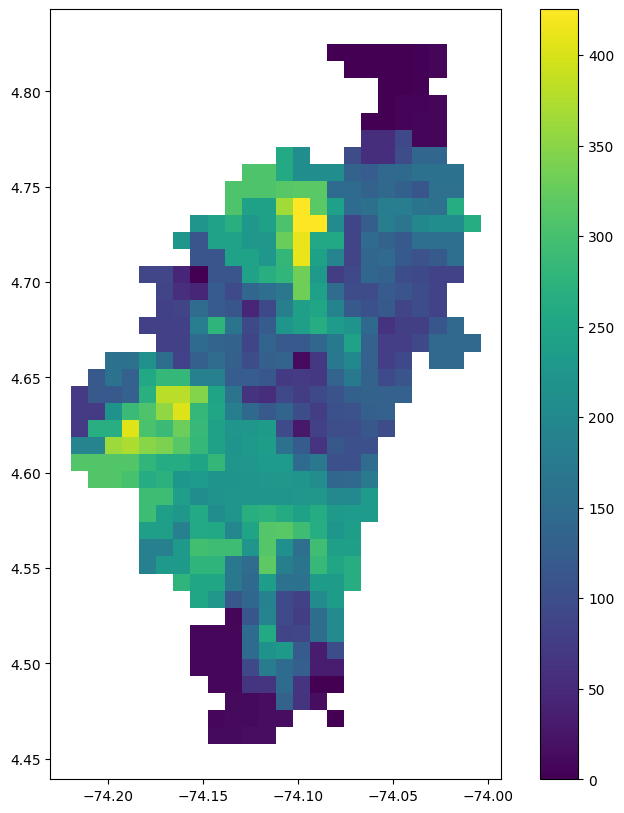

In [11]:
del population
gdf_grilla.plot(column='densidad_urbana', cmap='viridis', legend=True, figsize=(10,10))

#Adding poverty rate for each grid cell

In [12]:
localidades = gpd.read_file('../Data/Bogota/Raw Data/poligonos-localidades.geojson',driver='GeoJSON')
gdf_grilla = gpd.read_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
poverty = pd.read_csv('../Data/Bogota/Raw Data/covariates/poverty_rate.csv',encoding='latin-1',sep=";")
poverty.head()

,Año,Localidad,Indicador,Categoría,Sexo,Valor
0,2018,Bogotá D.C.,Privaciones,Analfabetismo,Ambos sexos,"1,6"
1,2018,Bogotá D.C.,Privaciones,Bajo logro educativo,Ambos sexos,"18,6"
2,2018,Bogotá D.C.,Privaciones,Barreras a servicios para cuidado de la primer...,Ambos sexos,"9,4"
3,2018,Bogotá D.C.,Privaciones,Barreras de acceso a servicios de salud,Ambos sexos,"1,2"
4,2018,Bogotá D.C.,Privaciones,Desempleo de larga duración,Ambos sexos,"12,8"


In [13]:
gdf_grilla.shape

(984, 4)

In [14]:
localidades.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,geo_point_2d,geometry
0,CIUDAD BOLIVAR,Acuerdo 14 de 1983,"130002593,080624",19,"{'lon': -74.16195890440652, 'lat': 4.482460265...","MULTIPOLYGON (((-74.18135 4.58892, -74.18092 4..."
1,SUBA,Acuerdo 8 de 1977,"100560477,718254",11,"{'lon': -74.0758452755469, 'lat': 4.7632081213...","MULTIPOLYGON (((-74.03450 4.82547, -74.03489 4..."
2,RAFAEL URIBE URIBE,Acuerdo 117 de 2003,"13834084,806513",18,"{'lon': -74.11336318293525, 'lat': 4.566476900...","MULTIPOLYGON (((-74.12803 4.59254, -74.12829 4..."
3,KENNEDY,Acuerdo 8 de 1977,"38589733,814235",08,"{'lon': -74.15266762383382, 'lat': 4.630347351...","MULTIPOLYGON (((-74.11830 4.63741, -74.11854 4..."
4,USME,Acuerdo 15 de 1993,"215066686,644374",05,"{'lon': -74.14280649581936, 'lat': 4.390025128...","MULTIPOLYGON (((-74.05597 4.50832, -74.05599 4..."


In [15]:
# same crs
gdf_grilla = gdf_grilla.to_crs('EPSG:4326')
localidades = localidades.to_crs('EPSG:4326')

# centroid of each cell grid
gdf_grilla['centroide'] = gdf_grilla.geometry.centroid

# Crear un GeoDataFrame con los centroides
centros = gpd.GeoDataFrame(gdf_grilla[['grid_id']], geometry=gdf_grilla['centroide'], crs='EPSG:4326')

# Spatial join entre centroide y localidades
centros_localidad = gpd.sjoin(centros, localidades, how='left', predicate='within')

# Agregar el nombre de la localidad de vuelta a la grilla
gdf_grilla = gdf_grilla.merge(centros_localidad[['grid_id', 'Nombre de la localidad']], on='grid_id', how='left')

gdf_grilla.head()

/var/folders/f5/3603lrxn363_ddpmt3c65sfm0000gn/T/ipykernel_3456/2015813454.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_grilla['centroide'] = gdf_grilla.geometry.centroid


,grid_id,tpg2017,densidad_urbana,geometry,centroide,Nombre de la localidad
0,0,NaN,NaN,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",POINT (-74.21500 4.46206),NaN
1,1,NaN,NaN,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",POINT (-74.21500 4.47102),NaN
2,2,NaN,NaN,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",POINT (-74.21500 4.47997),NaN
3,3,NaN,NaN,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",POINT (-74.21500 4.48893),NaN
4,4,NaN,NaN,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",POINT (-74.21500 4.49788),NaN


In [16]:
gdf_grilla.shape

(984, 6)

In [17]:
poverty.Indicador.unique()

array(['Privaciones', 'IPM', 'Contrib IPM', 'Coeficiente de Gini',
       'Pobreza monetaria', 'Pobreza monetaria extrema'], dtype=object)

In [18]:
poverty.query("Indicador=='Pobreza monetaria'").Localidad.unique()

array(['Bogotá D.C.', 'Usaquén', 'Chapinero', 'Santa Fe', 'San Cristóbal',
       'Usme', 'Tunjuelito', 'Bosa', 'Kennedy', 'Fontibón', 'Engativá',
       'Suba', 'Barrios Unidos', 'Teusaquillo', 'Los Mártires',
       'Antonio Nariño', 'Puente Aranda', 'La Candelaria',
       'Rafael Uribe Uribe', 'Ciudad Bolívar', 'Sumapaz'], dtype=object)

In [19]:
gdf_grilla["Nombre de la localidad"].unique()

array([nan, 'BOSA', 'CIUDAD BOLIVAR', 'KENNEDY', 'FONTIBON', 'TUNJUELITO',
       'ENGATIVA', 'USME', 'PUENTE ARANDA', 'RAFAEL URIBE URIBE', 'SUBA',
       'ANTONIO NARIÑO', 'SAN CRISTOBAL', 'LOS MARTIRES', 'TEUSAQUILLO',
       'BARRIOS UNIDOS', 'SANTA FE', 'CANDELARIA', 'CHAPINERO', 'USAQUEN'],
      dtype=object)

In [20]:
# map dictionary
mapeo_localidades = {
    'Usaquén': 'USAQUEN',
    'Chapinero': 'CHAPINERO',
    'Santa Fe': 'SANTA FE',
    'San Cristóbal': 'SAN CRISTOBAL',
    'Usme': 'USME',
    'Tunjuelito': 'TUNJUELITO',
    'Bosa': 'BOSA',
    'Kennedy': 'KENNEDY',
    'Fontibón': 'FONTIBON',
    'Engativá': 'ENGATIVA',
    'Suba': 'SUBA',
    'Barrios Unidos': 'BARRIOS UNIDOS',
    'Teusaquillo': 'TEUSAQUILLO',
    'Los Mártires': 'LOS MARTIRES',
    'Antonio Nariño': 'ANTONIO NARIÑO',
    'Puente Aranda': 'PUENTE ARANDA',
    'La Candelaria': 'CANDELARIA',
    'Rafael Uribe Uribe': 'RAFAEL URIBE URIBE',
    'Ciudad Bolívar': 'CIUDAD BOLIVAR',
    'Bogotá D.C.': np.nan,  # no tiene mapeo directo
    'Sumapaz': np.nan        # no aparece en tu lista estándar
}

In [21]:
poverty = poverty.query("Indicador=='Pobreza monetaria' and Año==2021")
poverty['Nombre de la localidad'] = poverty['Localidad'].map(mapeo_localidades)
poverty.dropna(inplace=True)
poverty.head()

,Año,Localidad,Indicador,Categoría,Sexo,Valor,Nombre de la localidad
315,2021,Usaquén,Pobreza monetaria,No aplica,Ambos sexos,"15,96",USAQUEN
316,2021,Chapinero,Pobreza monetaria,No aplica,Ambos sexos,"12,83",CHAPINERO
317,2021,Santa Fe,Pobreza monetaria,No aplica,Ambos sexos,"47,69",SANTA FE
318,2021,San Cristóbal,Pobreza monetaria,No aplica,Ambos sexos,"48,45",SAN CRISTOBAL
319,2021,Usme,Pobreza monetaria,No aplica,Ambos sexos,"57,81",USME


In [22]:
gdf_grilla.shape

(984, 6)

In [23]:
gdf_grilla = gdf_grilla.merge(
                              poverty,
                              left_on='Nombre de la localidad',
                              right_on='Nombre de la localidad',
                              how='left'
                          )

gdf_grilla.drop(columns=['Año','Localidad','Indicador','Categoría','Sexo','centroide'],inplace=True)
gdf_grilla.rename(columns={'Valor':'pobreza_monetaria'},inplace=True)
gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,geometry,Nombre de la localidad,pobreza_monetaria
0,0,NaN,NaN,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",NaN,NaN
1,1,NaN,NaN,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",NaN,NaN
2,2,NaN,NaN,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",NaN,NaN
3,3,NaN,NaN,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",NaN,NaN
4,4,NaN,NaN,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",NaN,NaN


In [24]:
def convertir_a_float(valor):
    try:
        # Limpieza básica (ajusta según tu dataset)
        valor = str(valor).replace('%', '').replace(',', '.').strip()
        return float(valor)
    except:
        return np.nan  # Si no se puede convertir, devuelve NaN

gdf_grilla['pobreza_monetaria_float'] = gdf_grilla['pobreza_monetaria'].apply(convertir_a_float)
gdf_grilla.drop(columns=['pobreza_monetaria'],inplace=True)
gdf_grilla.rename(columns={'pobreza_monetaria_float':'pobreza_monetaria'},inplace=True)

gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,geometry,Nombre de la localidad,pobreza_monetaria
0,0,NaN,NaN,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",NaN,NaN
1,1,NaN,NaN,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",NaN,NaN
2,2,NaN,NaN,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",NaN,NaN
3,3,NaN,NaN,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",NaN,NaN
4,4,NaN,NaN,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",NaN,NaN


In [25]:
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,geometry,Nombre de la localidad,pobreza_monetaria
0,0,NaN,NaN,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",NaN,NaN
1,1,NaN,NaN,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",NaN,NaN
2,2,NaN,NaN,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",NaN,NaN
3,3,NaN,NaN,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",NaN,NaN
4,4,NaN,NaN,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",NaN,NaN


In [26]:
gdf_grilla[gdf_grilla.pobreza_monetaria.notna()]

,grid_id,tpg2017,densidad_urbana,geometry,Nombre de la localidad,pobreza_monetaria
17,17,60.070520,191.566568,"POLYGON ((-74.21051 4.60982, -74.21051 4.61877...",BOSA,53.18
18,18,60.070520,73.563395,"POLYGON ((-74.21051 4.61877, -74.21051 4.62773...",BOSA,53.18
19,19,60.070520,73.563395,"POLYGON ((-74.21051 4.62773, -74.21051 4.63668...",BOSA,53.18
20,20,60.070520,73.563395,"POLYGON ((-74.21051 4.63668, -74.21051 4.64563...",BOSA,53.18
57,57,60.070520,309.569740,"POLYGON ((-74.20153 4.60087, -74.20153 4.60982...",BOSA,53.18
...,...,...,...,...,...,...
973,973,64.027285,264.024478,"POLYGON ((-74.00390 4.72621, -74.00390 4.73517...",USAQUEN,15.96
974,974,64.027285,NaN,"POLYGON ((-74.00390 4.73517, -74.00390 4.74412...",USAQUEN,15.96
981,981,64.027285,NaN,"POLYGON ((-74.00390 4.79783, -74.00390 4.80678...",USAQUEN,15.96
982,982,64.027285,NaN,"POLYGON ((-74.00390 4.80678, -74.00390 4.81573...",USAQUEN,15.96


<Axes: >

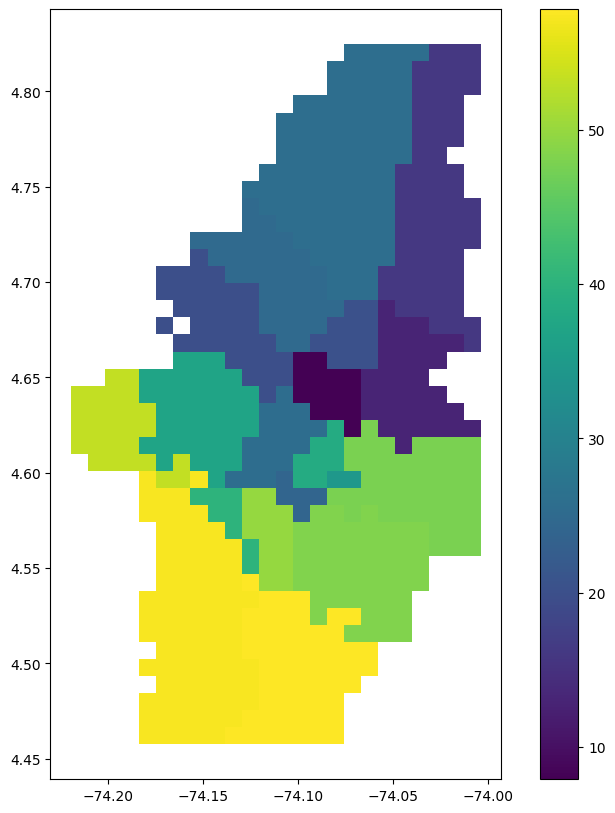

In [27]:
del poverty
gdf_grilla.plot(column='pobreza_monetaria', cmap='viridis', legend=True, figsize=(10,10))

#Adding land use for each grid cell

In [28]:
land_use = gpd.read_file('../Data/Bogota/Raw Data/covariates/land_use.geojson',driver='GeoJSON')
land_use.head()

,objectid,mancodigo,uso,ano,shape_area,shape_len,geo_shape,geo_point_2d,geometry
0,391832,004513020,RESIDENCIAL,2019-12-31 20:00:00-05:00,1.958042e-07,0.003843,None,"{'lon': -74.21405966010447, 'lat': 4.613241516...","POLYGON ((-74.21372 4.61354, -74.21367 4.61352..."
1,391834,002589099,RESIDENCIAL,2019-12-31 20:00:00-05:00,1.868025e-05,0.040404,None,"{'lon': -74.1166043267566, 'lat': 4.5303438992...","POLYGON ((-74.11719 4.53345, -74.11668 4.53360..."
2,392068,008506064,OTROS,2019-12-31 20:00:00-05:00,1.711463e-07,0.002262,None,"{'lon': -74.02579730346349, 'lat': 4.734638010...","POLYGON ((-74.02581 4.73416, -74.02582 4.73414..."
3,392071,008506060,RESIDENCIAL,2019-12-31 20:00:00-05:00,1.567529e-07,0.001683,None,"{'lon': -74.02934900660577, 'lat': 4.736112455...","POLYGON ((-74.02925 4.73588, -74.02925 4.73588..."
4,392072,008506065,OTROS,2019-12-31 20:00:00-05:00,2.587448e-07,0.002912,None,"{'lon': -74.02696793318606, 'lat': 4.735441878...","POLYGON ((-74.02683 4.73499, -74.02683 4.73498..."


In [29]:
from scipy.stats import mode

# 1. same CRS
gdf_grilla = gdf_grilla.to_crs('EPSG:4326')
land_use = land_use.to_crs('EPSG:4326')

# 2. Spatial join: asignar a cada uso del suelo el cuadrado que lo contiene
join = gpd.sjoin(land_use, gdf_grilla[['geometry', 'grid_id']], how='inner', predicate='intersects')

# 4. Calcular la moda (valor más frecuente) por grid_id
# Agrupamos y aplicamos moda de strings
uso_moda = join.groupby('grid_id')['uso'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index()

# 5. Agregar la moda de 'uso' a gdf_grilla
gdf_grilla = gdf_grilla.merge(uso_moda, on='grid_id', how='left')

In [30]:
gdf_grilla.shape

(984, 7)

In [31]:
del land_use
gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,geometry,Nombre de la localidad,pobreza_monetaria,uso
0,0,NaN,NaN,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",NaN,NaN,NaN
1,1,NaN,NaN,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",NaN,NaN,NaN
2,2,NaN,NaN,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",NaN,NaN,NaN
3,3,NaN,NaN,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",NaN,NaN,NaN
4,4,NaN,NaN,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",NaN,NaN,NaN


#Adding socioeconomical segregation index for each grid cell

In [46]:
#estrato = gpd.read_file('../Data/Bogota/Raw Data/covariates/estrato.geojson',driver='GeoJSON')
estrato = gpd.read_file('../Data/Bogota/Raw Data/covariates/estrato.shp')
estrato.head()

,OBJECTID,CODIGO_MAN,ESTRATO,CODIGO_ZON,CODIGO_CRI,NORMATIVA,ACTO_ADMIN,NUMERO_ACT,FECHA_ACTO,ESCALA_CAP,FECHA_CAPT,RESPONSABL,SHAPE_AREA,SHAPE_LEN,geometry
0,695738,00820516,5,15,None,DEC551,DEC,551,2019-09-12,None,2019-09-12,560,21725.000837,676.305821,"POLYGON ((-74.05448 4.64394, -74.05449 4.64392..."
1,695739,00460146,2,5,None,DEC551,DEC,551,2019-09-12,None,2019-09-12,560,1440.019910,183.987736,"POLYGON ((-74.16792 4.64359, -74.16794 4.64361..."
2,695740,00460145,2,4,None,DEC551,DEC,551,2019-09-12,None,2019-09-12,560,6646.540218,506.406054,"POLYGON ((-74.16791 4.64410, -74.16788 4.64412..."
3,695741,00454106,2,4,None,DEC551,DEC,551,2019-09-12,None,2019-09-12,560,1872.090078,239.992156,"POLYGON ((-74.17083 4.64415, -74.17076 4.64407..."
4,695742,00650102,3,7,None,DEC551,DEC,551,2019-09-12,None,2019-09-12,560,4393.406229,273.571554,"POLYGON ((-74.12984 4.64408, -74.12975 4.64413..."


In [47]:
# 1. same crs
gdf_grilla = gdf_grilla.to_crs('EPSG:4326')
estrato = estrato.to_crs('EPSG:4326')

# 2. Spatial join: asociar cada tgp con la celda que lo contiene (o intersecta)
joined = gpd.sjoin(estrato, gdf_grilla, how='inner', predicate='intersects')

# 3. groping by grid_id and making the average
promedios = joined.groupby('grid_id')['ESTRATO'].mean().reset_index()

# 4. mergin with the average values
gdf_grilla = gdf_grilla.merge(promedios, on='grid_id', how='left')

gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,geometry,uso_codificado,ESTRATO
0,0,-1.0,-1.0,-1,-1.0,-1,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",-1.0,NaN
1,1,-1.0,-1.0,-1,-1.0,-1,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",-1.0,NaN
2,2,-1.0,-1.0,-1,-1.0,-1,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",-1.0,NaN
3,3,-1.0,-1.0,-1,-1.0,-1,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",-1.0,NaN
4,4,-1.0,-1.0,-1,-1.0,-1,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",-1.0,NaN


In [48]:
gdf_grilla.shape

(984, 9)

<Axes: >

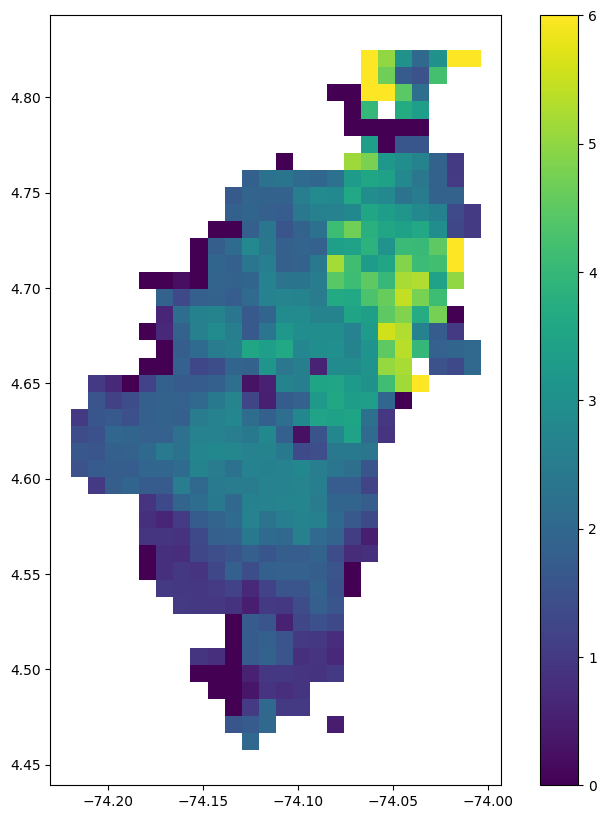

In [49]:
del estrato
gdf_grilla.plot(column='ESTRATO', cmap='viridis', legend=True, figsize=(10,10))

# Pair matching simetric

In [50]:
gdf_grilla = gpd.read_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,geometry
0,0,-1.0,-1.0,-1,-1.0,-1,-1.0,NaN,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654..."
1,1,-1.0,-1.0,-1,-1.0,-1,-1.0,NaN,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550..."
2,2,-1.0,-1.0,-1,-1.0,-1,-1.0,NaN,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445..."
3,3,-1.0,-1.0,-1,-1.0,-1,-1.0,NaN,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341..."
4,4,-1.0,-1.0,-1,-1.0,-1,-1.0,NaN,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236..."


In [51]:
usos = gdf_grilla['uso'].dropna().unique()

# Fijar semilla para reproducibilidad y mayor separación
np.random.seed(42)

# Generar valores numéricos aleatorios separados (ej. entre 100 y 9999)
valores_numericos = np.random.choice(range(100, 10000), size=len(usos), replace=False)

# Crear diccionario de mapeo
mapa_usos_numerico = dict(zip(usos, valores_numericos))

# Mostrar resultado
print("Diccionario de codificación aleatoria:")
print(mapa_usos_numerico)

Diccionario de codificación aleatoria:
{'-1': 8532, 'RESIDENCIAL': 5780, 'OTROS': 4867, 'BODEGAS': 9318, 'COMERCIO': 721, 'UNIVERSIDADES Y COLEGIOS': 3529}


In [52]:
gdf_grilla['uso_codificado'] = gdf_grilla['uso'].map(mapa_usos_numerico)
gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,geometry
0,0,-1.0,-1.0,-1,-1.0,-1,8532,NaN,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654..."
1,1,-1.0,-1.0,-1,-1.0,-1,8532,NaN,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550..."
2,2,-1.0,-1.0,-1,-1.0,-1,8532,NaN,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445..."
3,3,-1.0,-1.0,-1,-1.0,-1,8532,NaN,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341..."
4,4,-1.0,-1.0,-1,-1.0,-1,8532,NaN,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236..."


In [53]:
gdf_grilla.shape

(984, 9)

In [54]:
gdf_grilla.columns

Index(['grid_id', 'tpg2017', 'densidad_urbana', 'Nombre de la localidad',
       'pobreza_monetaria', 'uso', 'uso_codificado', 'ESTRATO', 'geometry'],
      dtype='object')

In [55]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np

def emparejamiento_simetrico(gdf, columnas_atributos, id_col='grid_id', seed=42):
    np.random.seed(seed)

    # 1. Extraer atributos y normalizar (opcional: mejora numérica)
    X = gdf[columnas_atributos].astype(float).values
    ids = gdf[id_col].values

    # 2. Calcular matriz de distancias
    dist_matrix = pairwise_distances(X, metric='euclidean')

    # 3. Llenar diagonal con np.inf para evitar auto-match
    np.fill_diagonal(dist_matrix, np.inf)

    # 4. Inicializar estructuras
    matched = {}          # id1 -> id2
    used_indices = set()  # índices usados

    # 5. Emparejamiento greedy simétrico sin reemplazo
    indices = np.random.permutation(len(X))
    for i in indices:
        if i in used_indices:
            continue
        # Buscar el más cercano no usado
        dists = dist_matrix[i].copy()
        dists[list(used_indices)] = np.inf  # excluir usados
        j = np.argmin(dists)
        if j == i or dists[j] == np.inf:
            continue
        # Registrar el emparejamiento simétrico
        matched[ids[i]] = ids[j]
        matched[ids[j]] = ids[i]
        used_indices.add(i)
        used_indices.add(j)

    # 6. Validación final: asegurar que todos estén emparejados
    no_match_ids = set(ids) - set(matched.keys())
    if no_match_ids:
        raise ValueError(f"No se pudo emparejar las siguientes celdas: {no_match_ids}")

    # 7. Asignar columna nueva
    gdf['grid_id_matching_simetric'] = gdf[id_col].map(matched)

    return gdf

In [56]:
#gdf_grilla['pobreza_monetaria'] = pd.to_numeric(gdf_grilla['pobreza_monetaria'], errors='coerce')
gdf_grilla.replace(np.nan, -1, inplace=True)
#gdf_grilla.dropna(inplace=True)

columnas = ['tpg2017', 'densidad_urbana', 'pobreza_monetaria', 'ESTRATO', 'uso_codificado']
gdf_grilla = emparejamiento_simetrico(gdf_grilla, columnas)

In [57]:
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,geometry,grid_id_matching_simetric
0,0,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",865
1,1,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",66
2,2,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",107
3,3,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",67
4,4,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",363


In [58]:
gdf_grilla.query('uso_codificado!=-1').head()

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,geometry,grid_id_matching_simetric
0,0,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",865
1,1,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",66
2,2,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",107
3,3,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",67
4,4,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",363


In [59]:
gdf_grilla.query('grid_id==16')

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,geometry,grid_id_matching_simetric
16,16,60.07052,309.56974,-1,-1.0,RESIDENCIAL,5780,1.5,"POLYGON ((-74.21051 4.60087, -74.21051 4.60982...",97


In [60]:
gdf_grilla.query('grid_id==97')

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,geometry,grid_id_matching_simetric
97,97,60.07052,309.56974,-1,-1.0,RESIDENCIAL,5780,1.766667,"POLYGON ((-74.19254 4.59191, -74.19254 4.60087...",16


In [61]:
gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')

# Pair matching asimetric

In [62]:
gdf_grilla = gpd.read_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,grid_id_matching_simetric,geometry
0,0,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,865,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654..."
1,1,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,66,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550..."
2,2,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,107,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445..."
3,3,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,67,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341..."
4,4,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,363,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236..."


In [63]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np

def emparejamiento_asimetrico(gdf, columnas_atributos, id_col='grid_id', seed=42):
    np.random.seed(seed)

    # 1. Filtrar registros con demasiada ausencia de datos (-1 en >2 campos)
    mask_valid = (gdf[columnas_atributos] != -1).sum(axis=1) >= (len(columnas_atributos) - 2)
    gdf = gdf[mask_valid].copy()

    # 2. Extraer atributos y convertir a float
    X = gdf[columnas_atributos].astype(float).values
    ids = gdf[id_col].values

    # 3. Calcular matriz de distancias inversas (mayor = más disímil)
    dist_matrix = pairwise_distances(X, metric='euclidean')
    np.fill_diagonal(dist_matrix, -np.inf)  # prohibir autoemparejamiento

    # 4. Inicializar estructuras
    matched = {}
    used_indices = set()

    # 5. Emparejamiento greedy maximizando disimilitud
    indices = np.random.permutation(len(X))
    for i in indices:
        if i in used_indices:
            continue

        # Buscar el más lejano (más disímil) que no esté usado
        dists = dist_matrix[i].copy()
        dists[list(used_indices)] = -np.inf
        j = np.argmax(dists)
        if j == i or dists[j] == -np.inf:
            continue

        matched[ids[i]] = ids[j]
        matched[ids[j]] = ids[i]
        used_indices.add(i)
        used_indices.add(j)

    # 6. Validación
    no_match_ids = set(ids) - set(matched.keys())
    if no_match_ids:
        print(f"Advertencia: sin pareja asignada para: {no_match_ids}")

    # 7. Asignar columna nueva
    gdf['grid_id_matching_asimetric'] = gdf[id_col].map(matched)

    return gdf

In [64]:
columnas = ['tpg2017', 'densidad_urbana', 'pobreza_monetaria', 'ESTRATO', 'uso_codificado']
gdf_grilla_asimetric = emparejamiento_asimetrico(gdf_grilla, columnas)

In [65]:
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,grid_id_matching_simetric,geometry
0,0,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,865,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654..."
1,1,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,66,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550..."
2,2,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,107,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445..."
3,3,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,67,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341..."
4,4,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,363,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236..."


In [66]:
gdf_grilla.shape

(984, 10)

In [67]:
gdf_grilla= gdf_grilla.merge(
                            gdf_grilla_asimetric[['grid_id','grid_id_matching_asimetric']],
                            left_on='grid_id',
                            right_on='grid_id',
                            how='left'
                        )

In [68]:
gdf_grilla.head()

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,grid_id_matching_simetric,geometry,grid_id_matching_asimetric
0,0,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,865,"POLYGON ((-74.21051 4.45758, -74.21051 4.46654...",NaN
1,1,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,66,"POLYGON ((-74.21051 4.46654, -74.21051 4.47550...",NaN
2,2,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,107,"POLYGON ((-74.21051 4.47550, -74.21051 4.48445...",NaN
3,3,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,67,"POLYGON ((-74.21051 4.48445, -74.21051 4.49341...",NaN
4,4,-1.0,-1.0,-1,-1.0,-1,8532,-1.0,363,"POLYGON ((-74.21051 4.49341, -74.21051 4.50236...",NaN


In [70]:
gdf_grilla.to_file('../Data/Bogota/Raw Data/grid_1kmx1km_bogota_covariates.geojson',driver='GeoJSON')
gdf_grilla[gdf_grilla['grid_id_matching_asimetric'].notna()]

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,grid_id_matching_simetric,geometry,grid_id_matching_asimetric
16,16,60.070520,309.569740,-1,-1.00,RESIDENCIAL,5780,1.500000,97,"POLYGON ((-74.21051 4.60087, -74.21051 4.60982...",778.0
17,17,60.070520,191.566568,BOSA,53.18,RESIDENCIAL,5780,1.633333,58,"POLYGON ((-74.21051 4.60982, -74.21051 4.61877...",389.0
18,18,60.070520,73.563395,BOSA,53.18,OTROS,4867,1.375000,19,"POLYGON ((-74.21051 4.61877, -74.21051 4.62773...",104.0
19,19,60.070520,73.563395,BOSA,53.18,OTROS,4867,1.000000,18,"POLYGON ((-74.21051 4.62773, -74.21051 4.63668...",915.0
20,20,60.070520,73.563395,BOSA,53.18,-1,8532,-1.000000,472,"POLYGON ((-74.21051 4.63668, -74.21051 4.64563...",374.0
...,...,...,...,...,...,...,...,...,...,...,...
973,973,64.027285,264.024478,USAQUEN,15.96,RESIDENCIAL,5780,1.000000,933,"POLYGON ((-74.00390 4.72621, -74.00390 4.73517...",575.0
974,974,64.027285,-1.000000,USAQUEN,15.96,RESIDENCIAL,5780,1.000000,776,"POLYGON ((-74.00390 4.73517, -74.00390 4.74412...",186.0
981,981,64.027285,-1.000000,USAQUEN,15.96,-1,8532,-1.000000,927,"POLYGON ((-74.00390 4.79783, -74.00390 4.80678...",382.0
982,982,64.027285,-1.000000,USAQUEN,15.96,-1,8532,-1.000000,941,"POLYGON ((-74.00390 4.80678, -74.00390 4.81573...",220.0


In [71]:
gdf_grilla.query('grid_id==942')

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,grid_id_matching_simetric,geometry,grid_id_matching_asimetric
942,942,64.027285,-1.0,USAQUEN,15.96,-1,8532,6.0,983,"POLYGON ((-74.01288 4.81573, -74.01288 4.82468...",625.0


In [72]:
gdf_grilla.query('grid_id==983')

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,grid_id_matching_simetric,geometry,grid_id_matching_asimetric
983,983,64.027285,-1.0,USAQUEN,15.96,-1,8532,6.0,942,"POLYGON ((-74.00390 4.81573, -74.00390 4.82468...",300.0


In [73]:
gdf_grilla.query('grid_id==57')

,grid_id,tpg2017,densidad_urbana,Nombre de la localidad,pobreza_monetaria,uso,uso_codificado,ESTRATO,grid_id_matching_simetric,geometry,grid_id_matching_asimetric
57,57,60.07052,309.56974,BOSA,53.18,RESIDENCIAL,5780,1.690722,504,"POLYGON ((-74.20153 4.60087, -74.20153 4.60982...",569.0
